In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scvelo as scv
import os
import anndata as ad
import pandas as pd
from MIGC_utils import batch_ERSMI, show_xt, show_X_t, GO_enrich
plt.rcParams['figure.dpi'] = 300

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.cluster import mutual_info_score

torch.cuda.set_device(3)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)


In [16]:
dataset_name = '10x_mouse_brain' 

save_folder = 'Demo/' + dataset_name +'/'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

n_DEGs = 100

adata = ad.read_h5ad("data/10x_mouse_brain/adata_rna.h5ad") 
adata.obs['clusters'] = adata.obs['celltype'].copy()
categories_order = ['RG, Astro, OPC', 'IPC', 'V-SVZ', 'Ependymal cells', 'Upper Layer', 'Subplate', 'Deeper Layer']
adata.obs['clusters'] = adata.obs['clusters'].cat.reorder_categories(categories_order, ordered=True)
organism = 'mouse'

print(adata)


AnnData object with n_obs × n_vars = 3365 × 936
    obs: 'celltype', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'


Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3365 × 936
    obs: 'celltype', 'clusters', 'clusters_id', 'clusters_colors', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_colors', 'hvg', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'raw_counts', 'expression'
    obsp: 'distances', 'connectivities'


... storing 'clusters_colors' as categorical


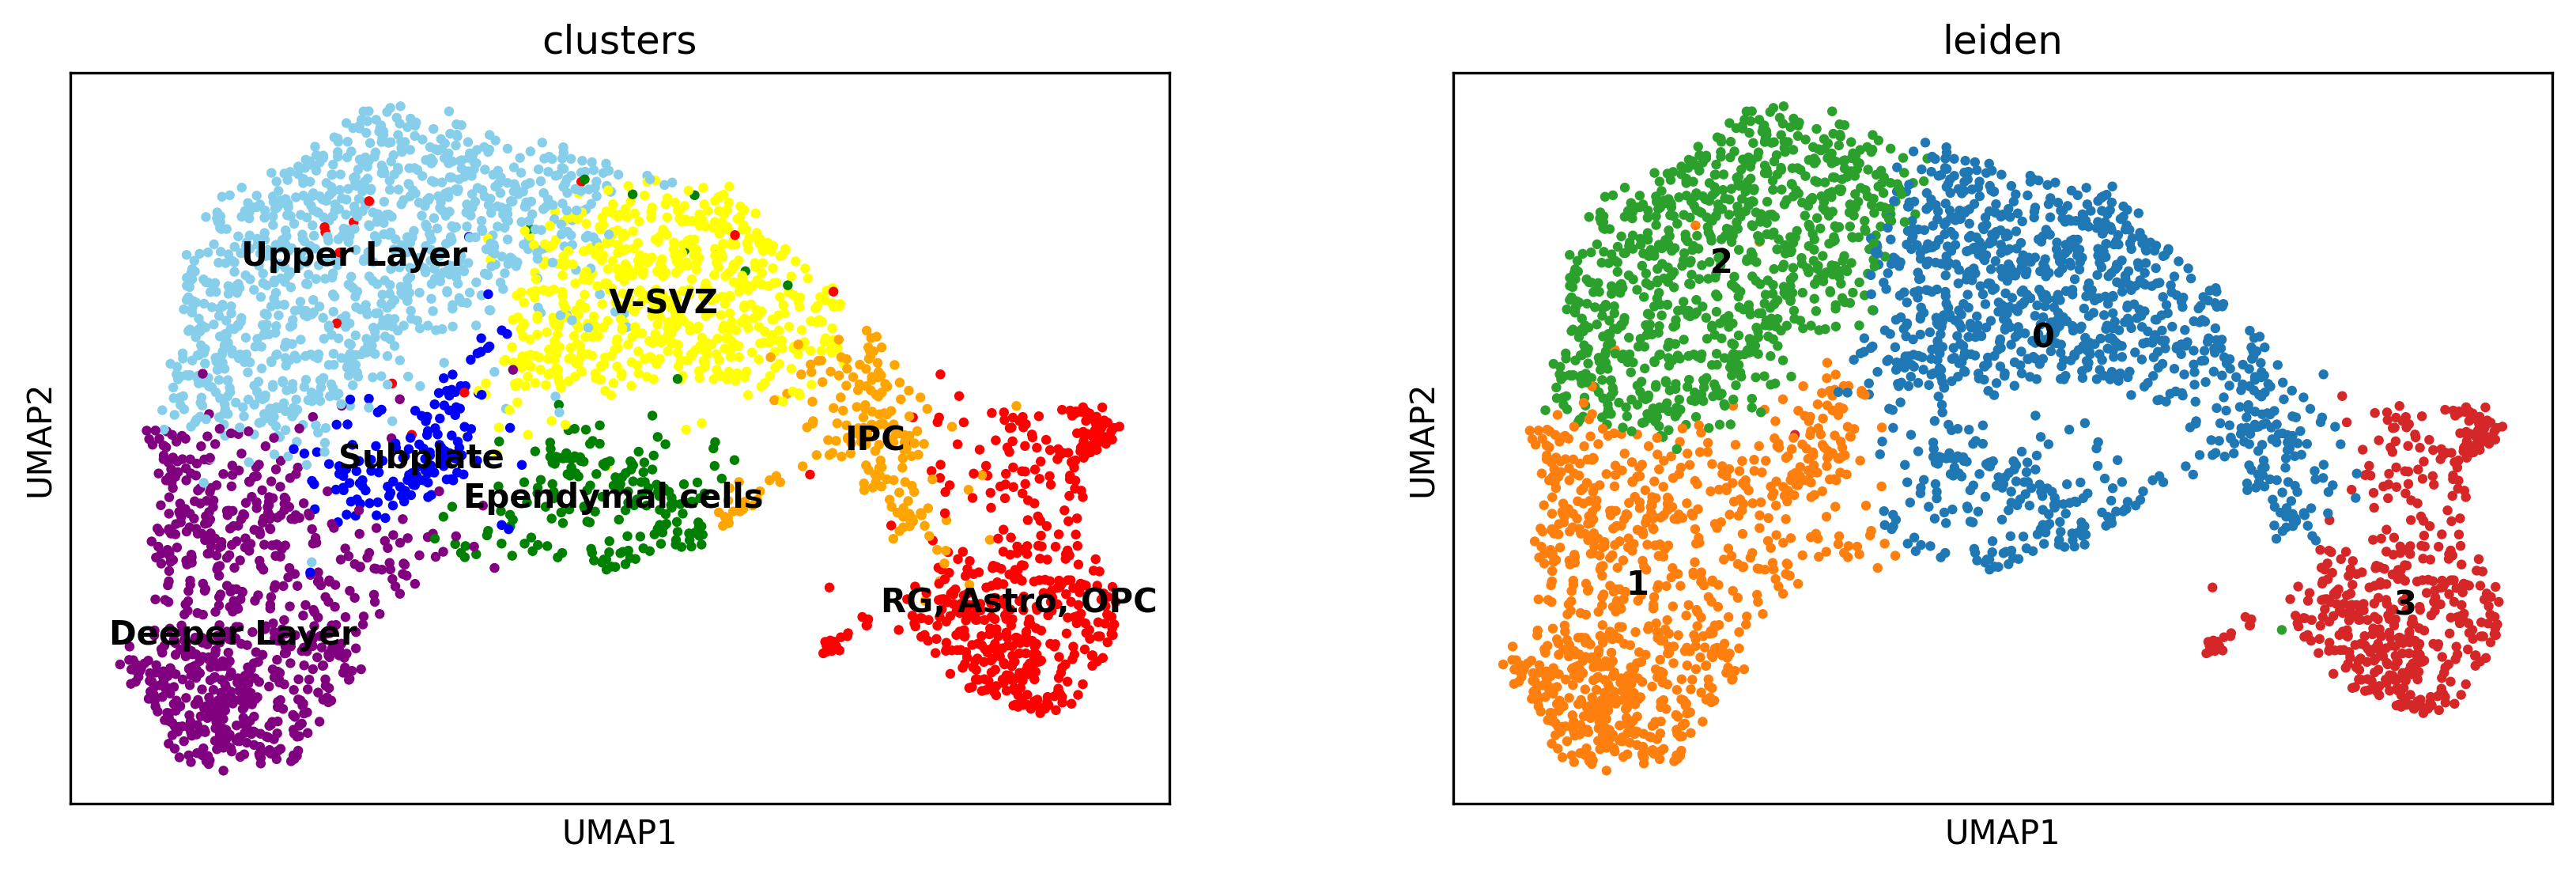

In [17]:
if 'clusters' not in adata.obs:
    if 'celltype' in adata.obs:
        adata.obs['clusters'] = adata.obs['celltype'].copy()
        if 'celltype_colors' in adata.uns:
            adata.uns['clusters_colors'] = adata.uns['celltype_colors'].copy()
cats = list(adata.obs['clusters'].cat.categories)
adata.uns['clusters_colors'] = np.array(['red', 'orange', 'yellow', 'green','skyblue', 'blue','purple', 'pink', '#8fbc8f', '#f4a460', '#fdbf6f', '#ff7f00', '#b2df8a', '#1f78b4',
        '#6a3d9a', '#cab2d6'][:len(cats)], dtype=object)  
clusters_id, clusters_colors = [], []
for c in adata.obs['clusters']:
    c_id = cats.index(c)
    clusters_id.append(c_id)
    clusters_colors.append(adata.uns['clusters_colors'][c_id])
adata.obs['clusters_id'] = clusters_id
adata.obs['clusters_colors'] = clusters_colors

if not 'spliced' in adata.layers:
    adata.layers['spliced'] = adata.X.copy()
    adata.layers['unspliced'] = adata.X.copy()
adata.layers['raw_counts'] = adata.X.copy()
scv.pp.filter_and_normalize(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")
adata = adata[:, adata.var.highly_variable]

scv.pp.moments(adata, n_pcs=30)
adata.layers['expression'] = adata.layers['Ms'].copy()
del adata.layers['Ms'], adata.layers['Mu'], adata.layers['spliced'], adata.layers['unspliced']

print(adata)

if 'X_pca' not in adata.obsm.keys():
    print('PCA ing')
    sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
    # sc.pl.pca(adata, color=['clusters'], show=False, save='_clusters.png')
if ('X_umap' not in adata.obsm.keys()):
    print('Umap ing')
    if not 'neighbors' in adata.uns.keys():
        sc.pp.neighbors(adata)
    sc.tl.umap(adata)
            
sc.tl.leiden(adata, key_added="leiden", resolution=0.2)
sc.pl.umap(adata, color=['clusters', 'leiden'], legend_loc='on data')

In [18]:
adata.uns['iroot_leiden'] = '3' 

adata.var['MI_leiden'] = 0.0
leiden = adata.obs['leiden']
for g_id, g in enumerate(adata.var_names):
    x = np.array(adata[:,g].layers['expression']).reshape(-1)
    adata.var['MI_leiden'][g_id] = mutual_info_score(x, leiden)

Epoch: 50  Loss: -0.38445472717285156
Epoch: 100  Loss: -0.38996416330337524
Epoch: 150  Loss: -0.39160680770874023
Epoch: 200  Loss: -0.39284056425094604
Epoch: 250  Loss: -0.3940387964248657
Epoch: 300  Loss: -0.3953064978122711
Epoch: 350  Loss: -0.39652734994888306
Epoch: 400  Loss: -0.39703452587127686
Epoch: 450  Loss: -0.3982468247413635
Epoch: 500  Loss: -0.39942067861557007
Final loss: -0.39942067861557007


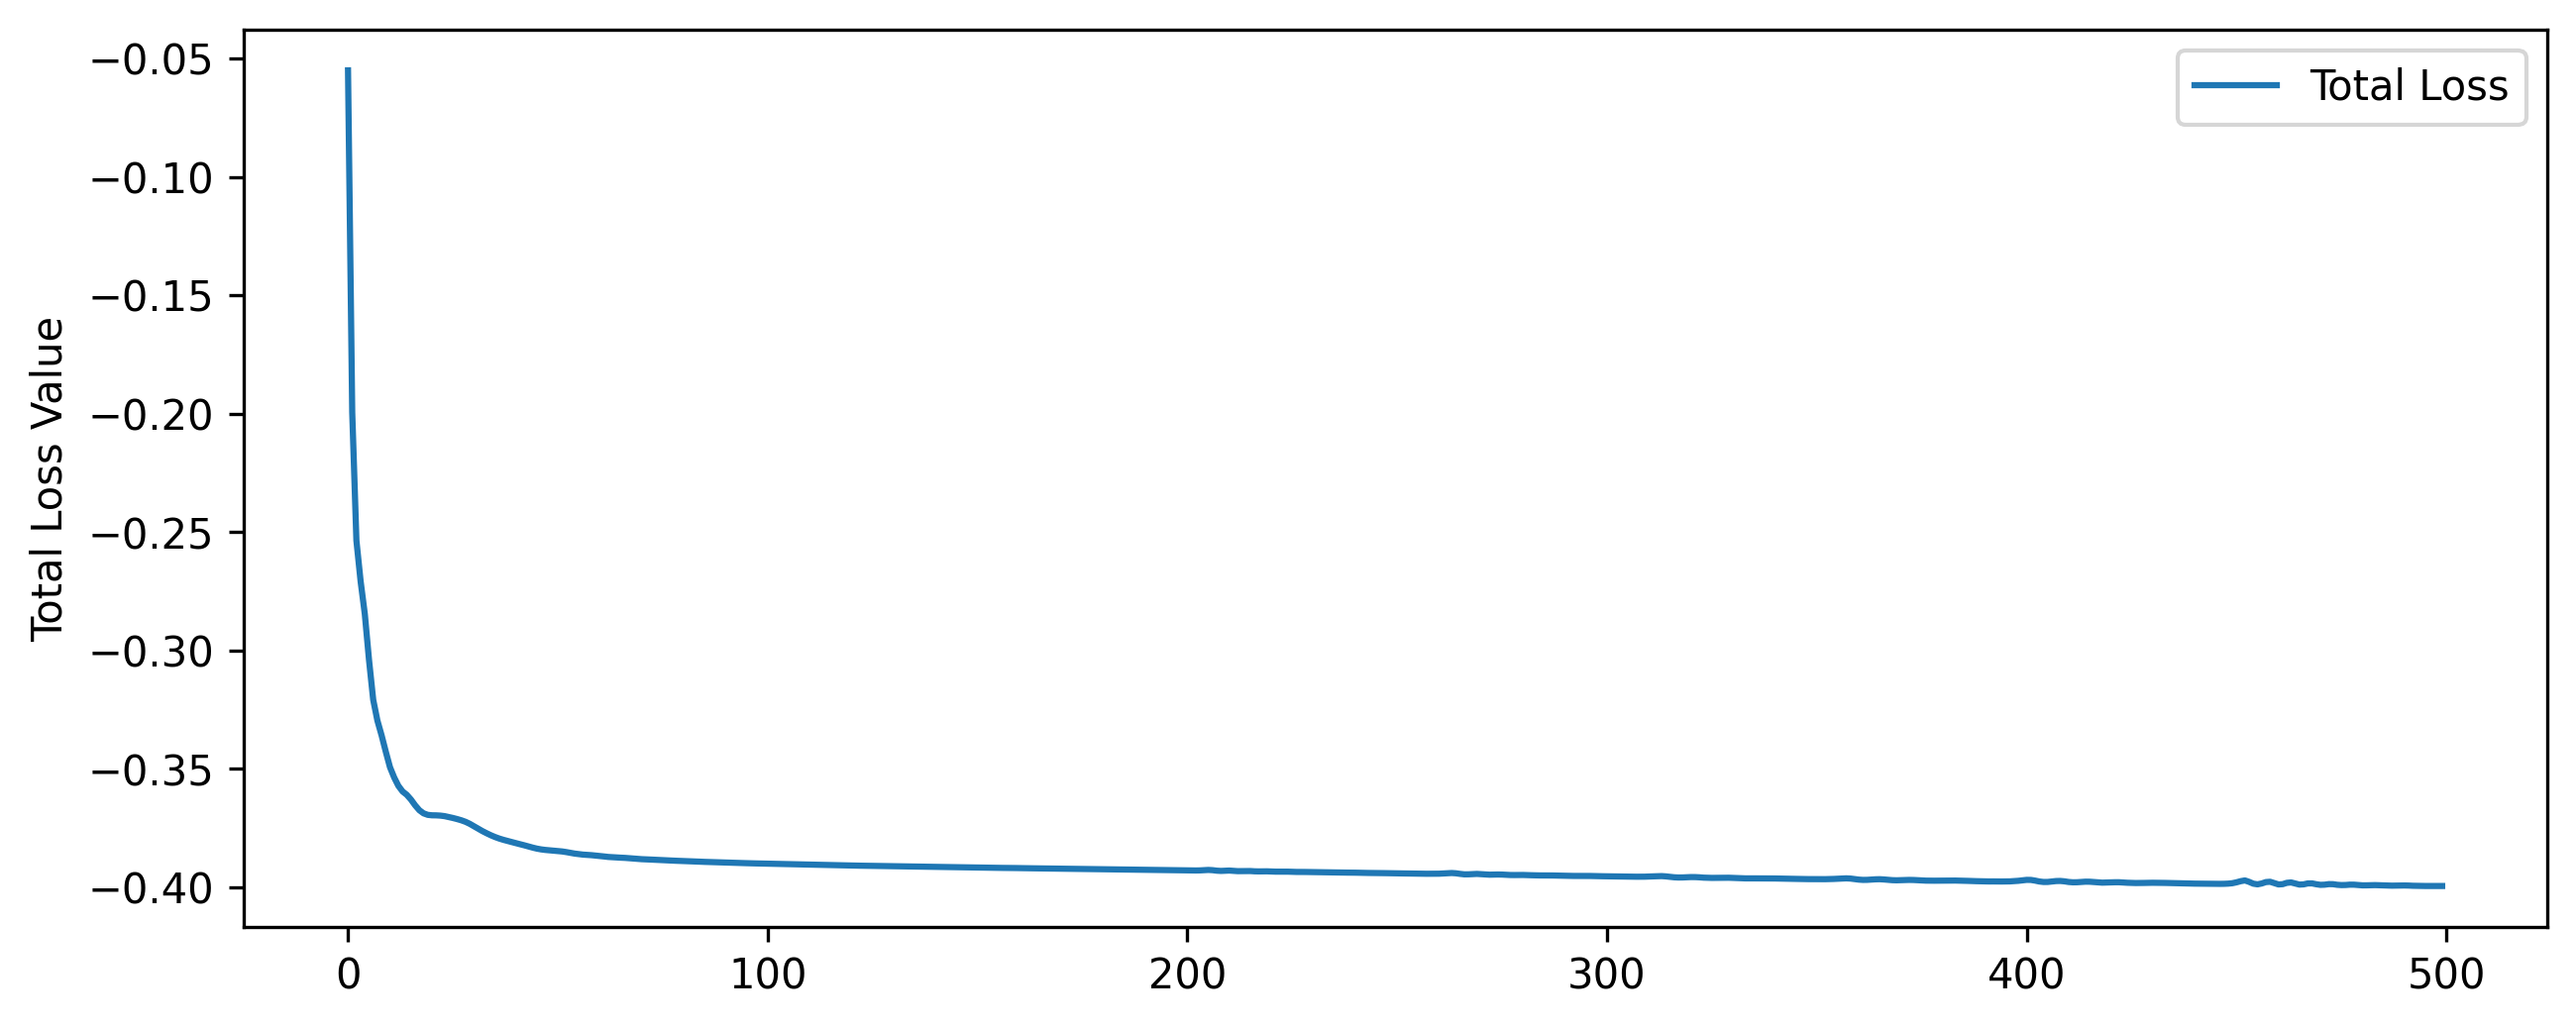

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, latent_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ELU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ELU(),
            nn.Linear(hidden_size2, latent_size),
            nn.Sigmoid()
        )


    def forward(self, x):
        latents = self.encoder(x)
        #outputs = self.decoder(latents)
        return latents#, outputs
    
n_genes = 200
if n_genes < adata.shape[1]:
    sorted_genes_MI_leiden = list(adata[:, adata.var['MI_leiden'].argsort()[::-1]].var_names[:n_genes])
    X_gene = adata[:,sorted_genes_MI_leiden].layers['expression']
else:
    X_gene = adata.layers['expression']
        
scaler = MinMaxScaler()#StandardScaler()
X_scaled = scaler.fit_transform(X_gene)

X_tensor = torch.FloatTensor(X_scaled).to('cuda')

batch_size = 4096
train_data_loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)

input_size = X_gene.shape[1]  
hidden_size1 = 128
hidden_size2 = 128
latent_size = 1
autoencoder = Encoder(input_size, hidden_size1, hidden_size2, latent_size).to('cuda')

#criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

num_epochs = 500
batch_size_ERSMI = 128
losses, losses_recon, losser_ERSMI = [], [], []
for epoch in range(num_epochs):
    losses_epoch, losses_recon_epoch, losser_ERSMI_epoch = [], [], []
    for inputs in train_data_loader:
        optimizer.zero_grad()
        input_gene = inputs[0]
        latents = autoencoder(input_gene)
        #loss_recon = criterion(outputs, input_gene) 
        loss_ERSMI = 0
        input_ERSMI = input_gene.T 
        n_gene_ERSMI = len(input_ERSMI)
        for i in range(1+int((n_gene_ERSMI-1)/batch_size_ERSMI)):
            batch_X_ERSMI = input_ERSMI[i*batch_size_ERSMI: (i+1)*batch_size_ERSMI]
            n_batch_X_ERSMI = len(batch_X_ERSMI)
            for l in range(latent_size):
                ERSMI = batch_ERSMI(batch_X_ERSMI, latents[:,l].reshape(1,-1).repeat(n_batch_X_ERSMI, 1))
                loss_ERSMI += - 1/latent_size * ERSMI.mean()
        loss = loss_ERSMI #+ loss_recon
        loss.backward()
        optimizer.step()
        losses_epoch.append(loss.item())
        #losses_recon_epoch.append(loss_recon.item())
        losser_ERSMI_epoch.append(loss_ERSMI.item())
    losses.append(np.array(losses_epoch).mean())
    #losses_recon.append(np.array(losses_recon_epoch).mean())
    losser_ERSMI.append(np.array(losser_ERSMI_epoch).mean())   
    if (epoch+1)%50==0:
        print('Epoch:', epoch+1, " Loss:", losses[-1])
 
print('Final loss:', losses[-1])   
fig, ax1 = plt.subplots(1, 1, figsize=(10, 4))
ax1.plot(losses, label='Total Loss')
ax1.set_ylabel('Total Loss Value')
ax1.legend()
plt.show()

In [20]:
test_data_loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=False)
autoencoder.eval()

latents_all = []
with torch.no_grad():
    for inputs in test_data_loader:
        X_gene = inputs[0]
        latents = autoencoder(X_gene)
        latents_all.append(latents.cpu().numpy())

latents_all = np.vstack(latents_all)
adata.obsm['X_MI'] = latents_all


root_MIt: 0.08213871


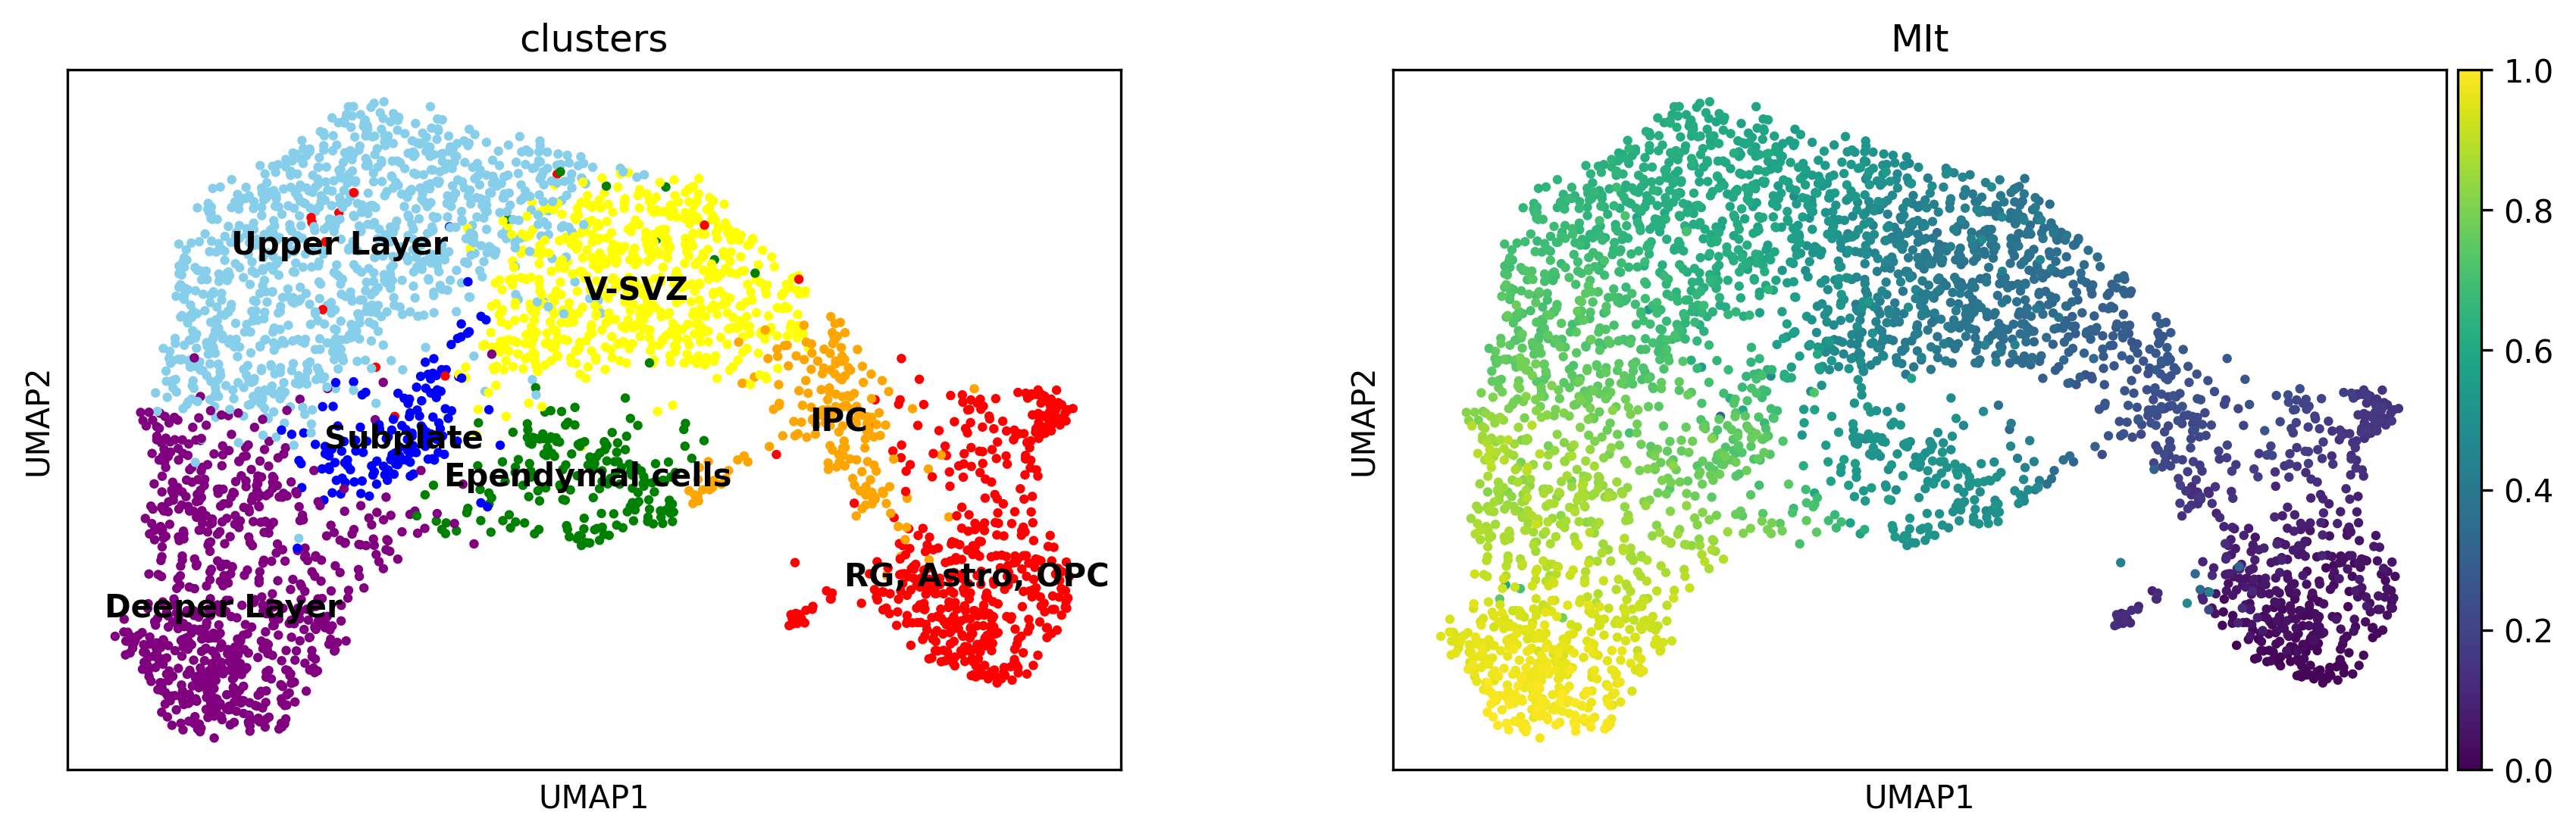

In [21]:
adata.obs['MIt'] = (adata.obsm['X_MI']-adata.obsm['X_MI'].min())/(adata.obsm['X_MI'].max()-adata.obsm['X_MI'].min())
root_MIt = adata[adata.obs['leiden']==adata.uns['iroot_leiden'],:].obs['MIt'].mean()
print('root_MIt:', root_MIt)
if root_MIt > 0.5:
    adata.obs['MIt'] = 1 - adata.obs['MIt']
#adata.obs['MIt'] = (adata.obs['MIt']-adata.obs['MIt'].min())/(adata.obs['MIt'].max()-adata.obs['MIt'].min())
sc.pl.umap(adata, color=['clusters', 'MIt'], legend_loc='on data')


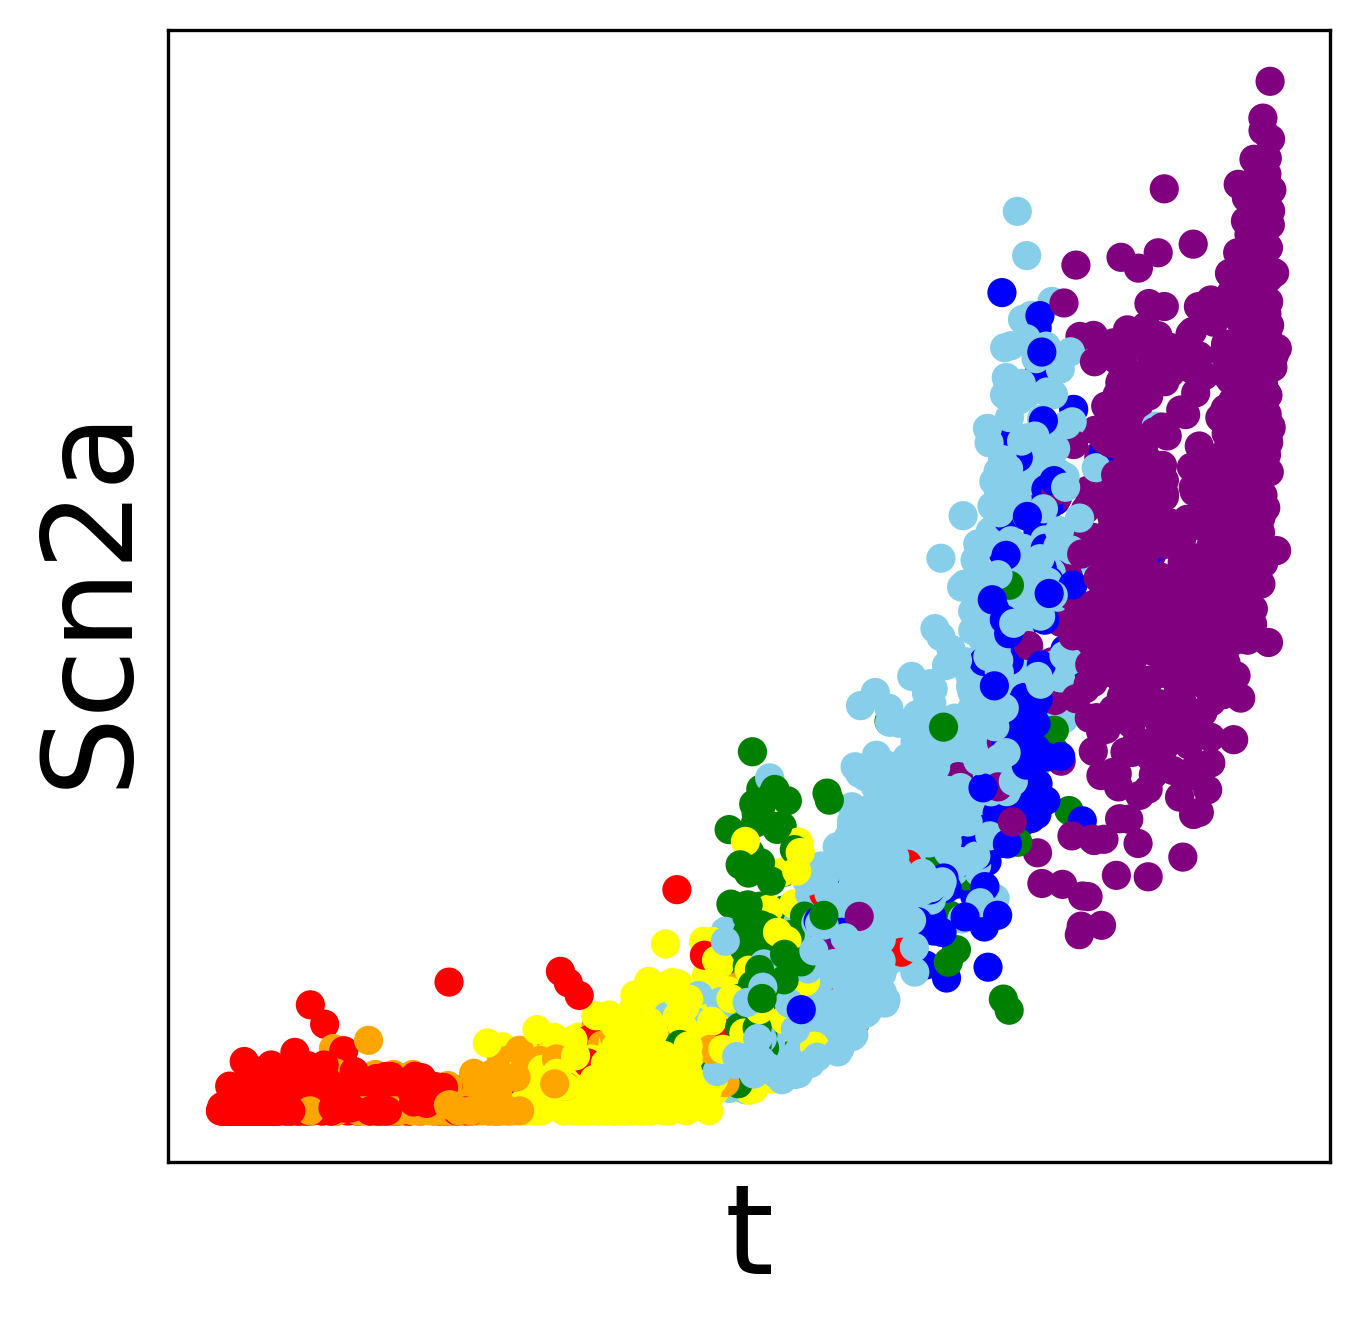

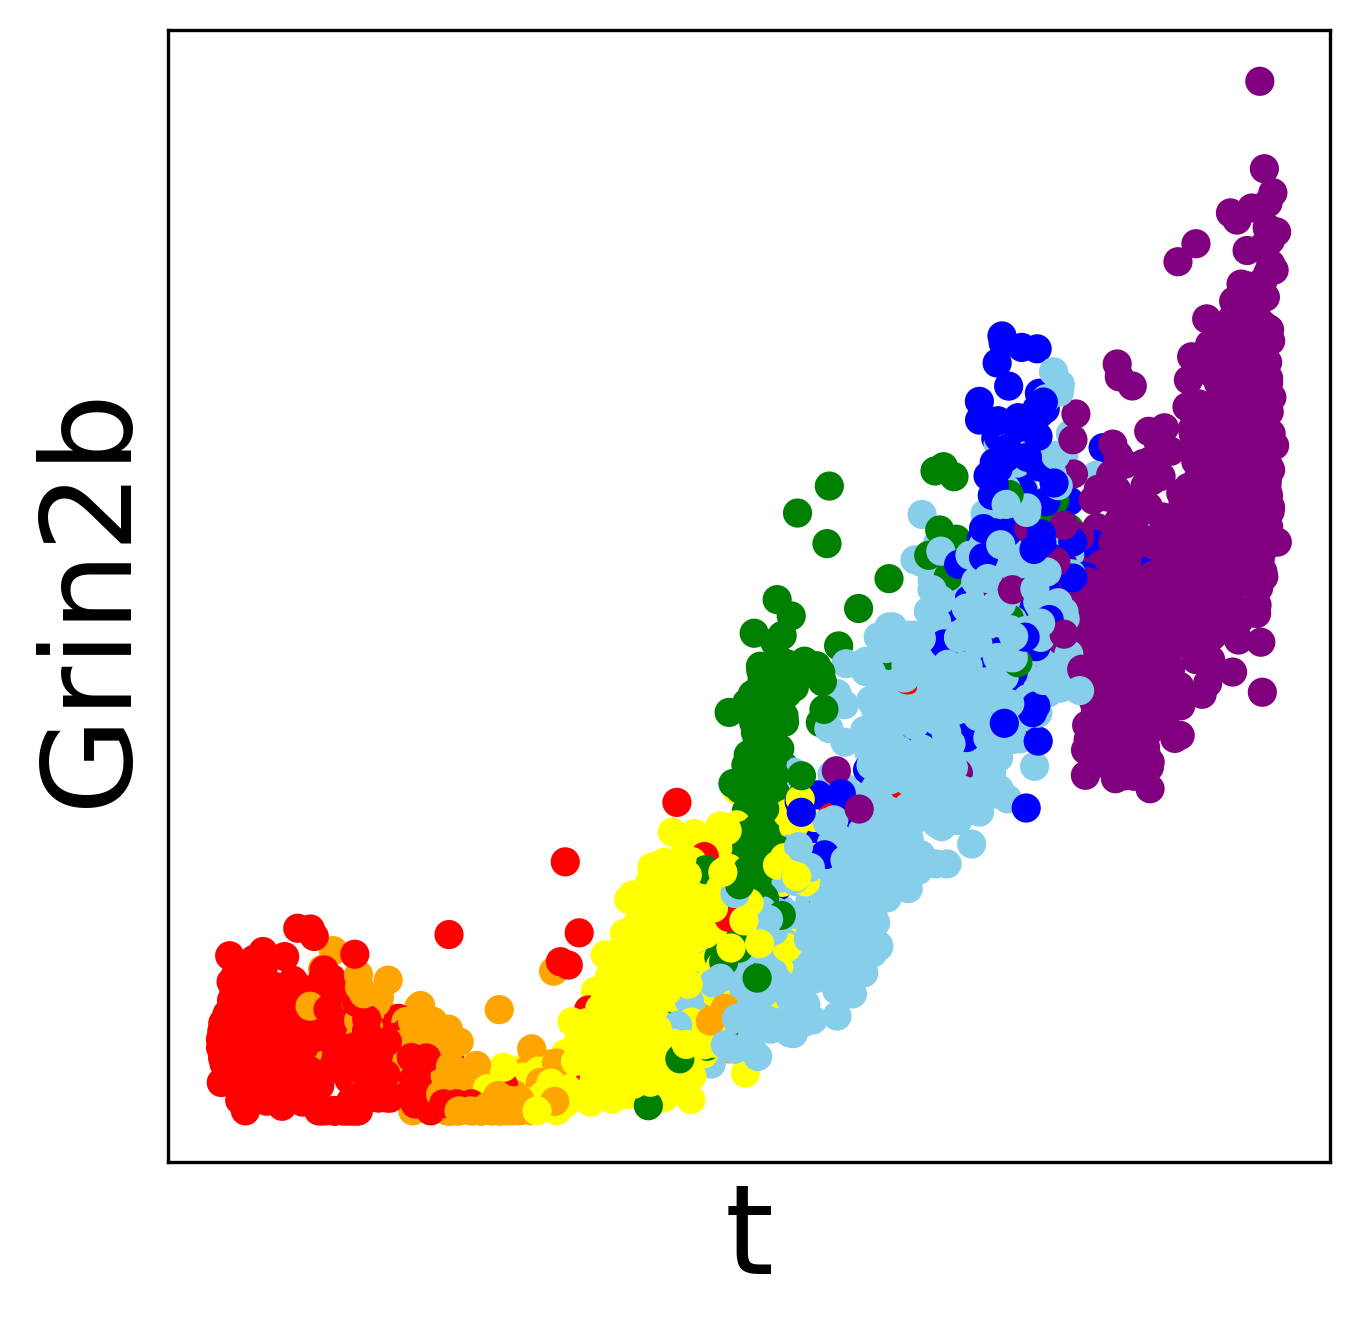

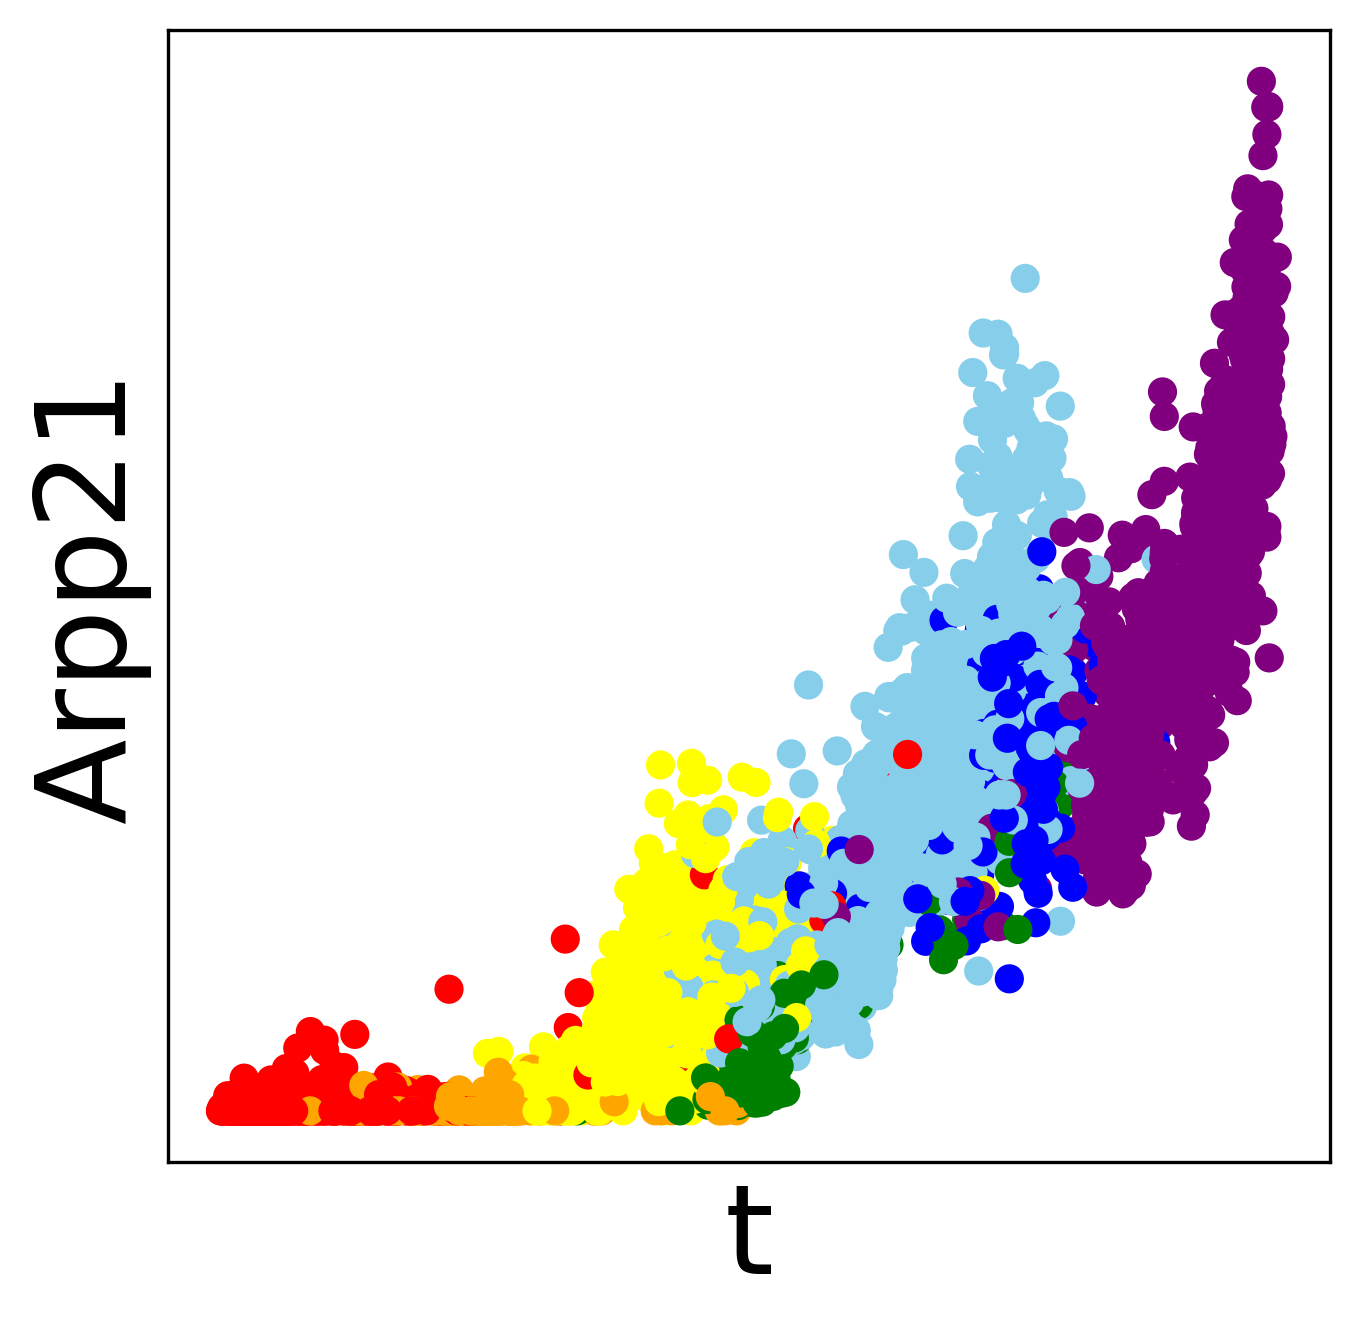

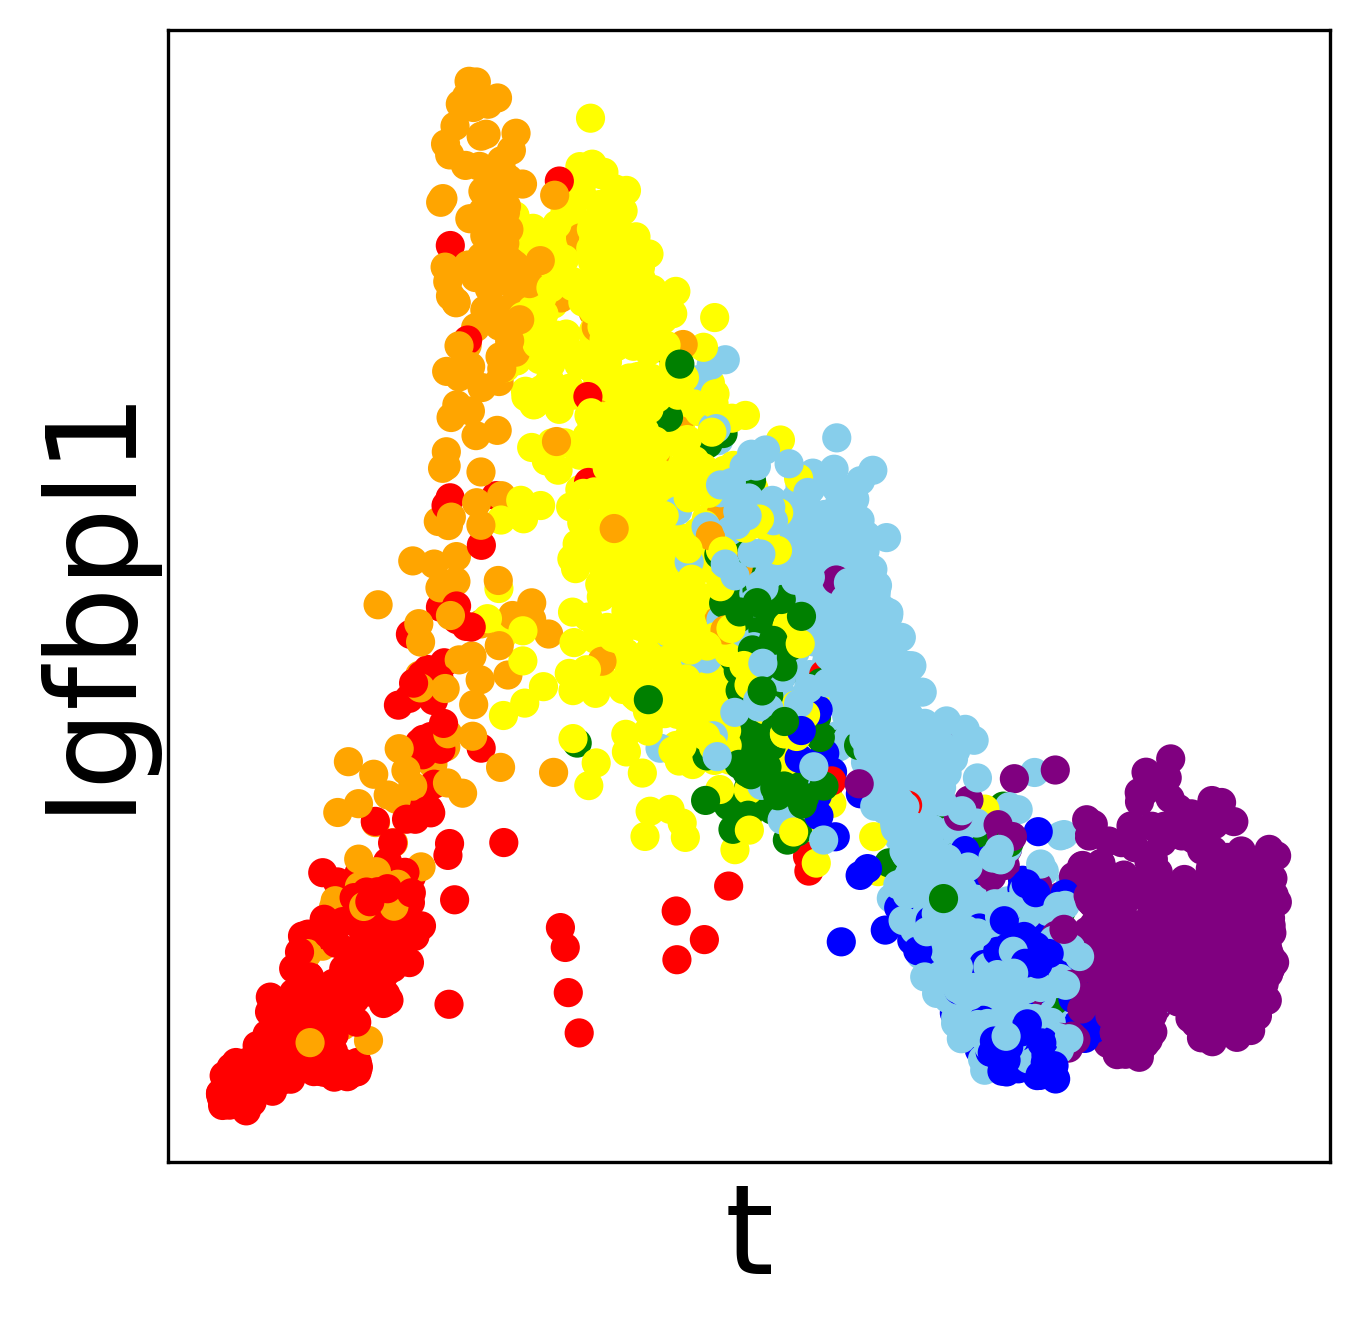

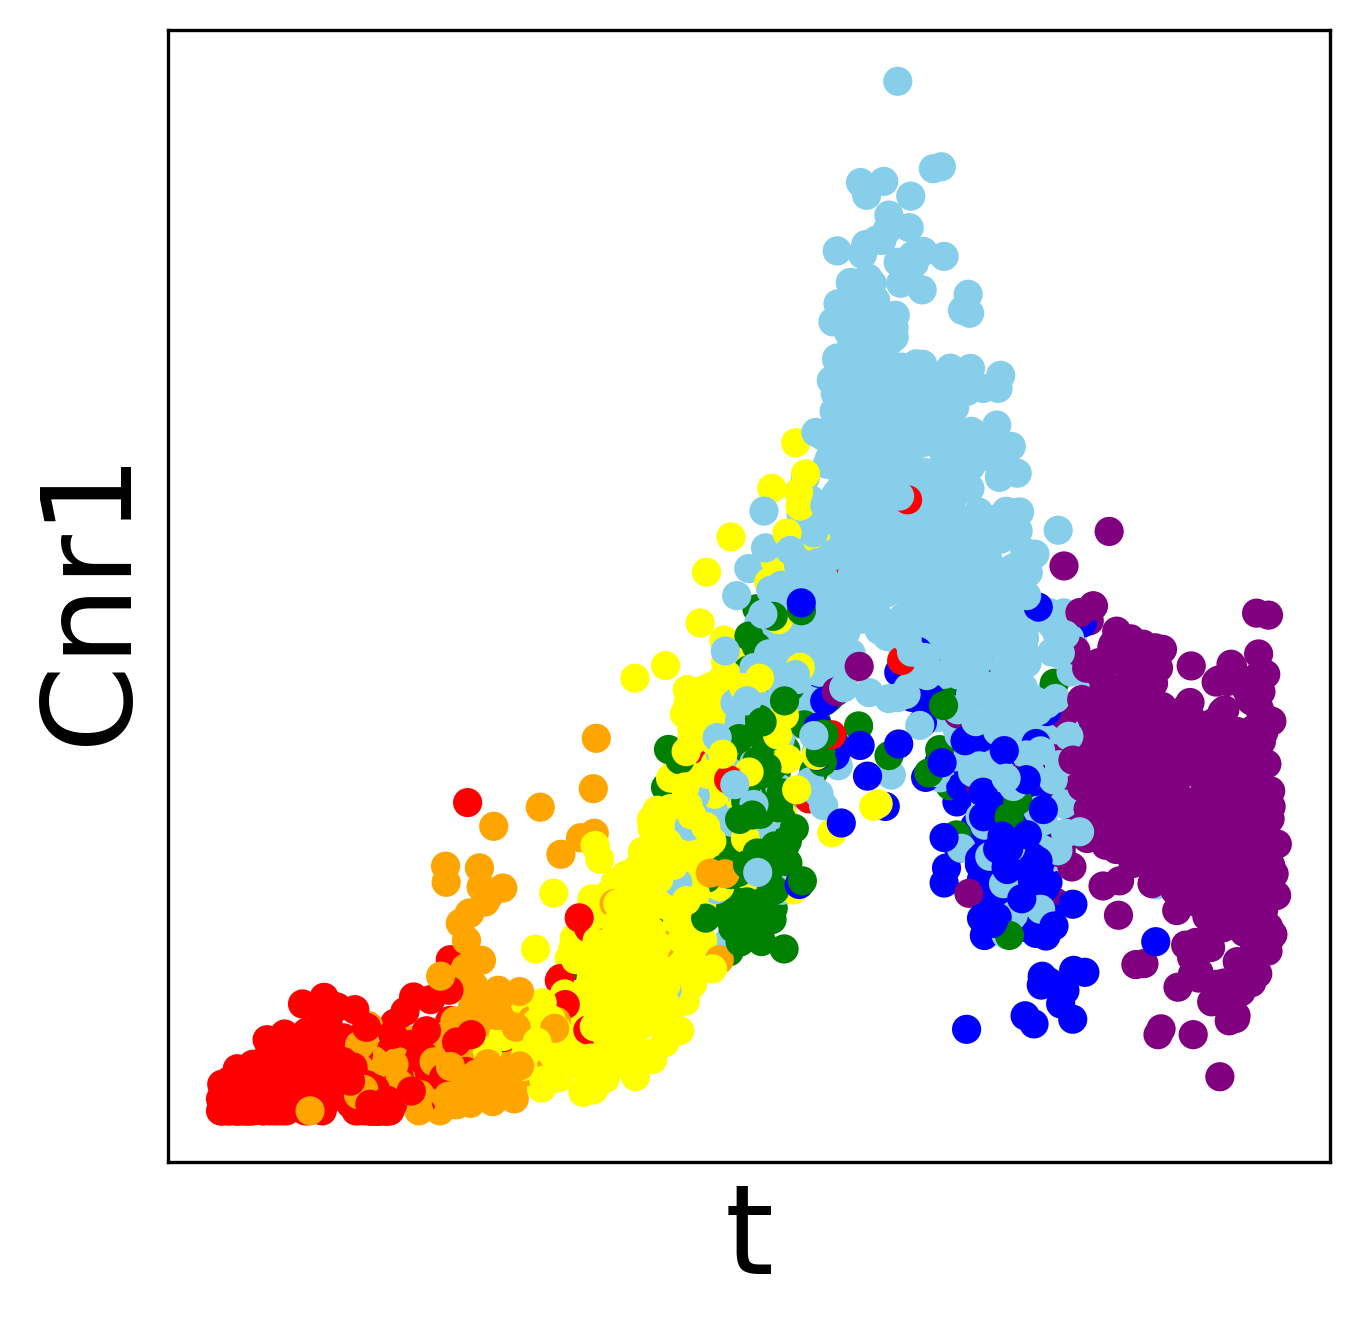

In [22]:
batch_size = 20
n_batch = int(adata.shape[1]/batch_size)
MIt_mat = torch.tensor(adata.obs['MIt']).reshape(1,-1).repeat(batch_size, 1)
adata.var['ERSMI_MIt'] = 0.0
x_mat = np.array(adata.layers['expression']).T
x_mat = x_mat/x_mat.max(1).reshape(-1,1)
for batch in range(n_batch):
    x = torch.tensor(x_mat)[batch*batch_size: (batch+1)*batch_size]
    batch_ersmi = batch_ERSMI(x.cuda(), MIt_mat.cuda()).cpu()
    for g_id in range(batch_size):
        adata.var['ERSMI_MIt'][batch*batch_size+g_id] = batch_ersmi[g_id]
del batch_ersmi

MIt = np.array(adata.obs['MIt'])
sorted_genes_ERSMI_MIt = adata[:, adata.var['ERSMI_MIt'].argsort()[::-1]].var_names
for g in sorted_genes_ERSMI_MIt[:5]:
    x = np.array(adata[:,g].layers['expression'])
    show_xt(x, MIt, g, c=adata.obs['clusters_colors'], text=None)#'ERSMI(x,MIt):'+str(round(adata[:,g].var['ERSMI_MIt'][0],3)))


In [23]:
DEG = list(sorted_genes_ERSMI_MIt[:n_DEGs])
background = list(adata.var_names)
GO_enrich(DEG, background, organism, figure_path=save_folder, save_name='ERSMI_MIt')

In [24]:
adata.write(save_folder + 'MIGC.h5ad')